In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.models
from PIL import Image

#I do not think you need any paths once it goes to github
#master_path = "/content/gdrive/My Drive/Colab Notebooks/APS360Project"
#master_path = "/content/gdrive/My Drive/APS360Project"

seed_value= 0

np.random.seed(seed_value)
torch.manual_seed(seed_value)

In [0]:
#Load original CNN model (trained already)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.name = "primary model"
        self.conv1 = nn.Conv2d(256, 64, 3)
        self.fc1 = nn.Linear(64*4*4, 200)
        self.fc2 = nn.Linear(200, 43)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

mod = ConvNet()

#mod.load_state_dict(torch.load(master_path + "/Model Checkpoint/model_primary model_bs64_lr0.001_epoch29"))
#Just upload this model along with this colab file to github
mod.load_state_dict(torch.load("model_primary model_bs64_lr0.001_epoch29"))

# Load the pre-trained alexnet model
alexNet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
#Faster RCNN with ResNet50 backbone
faster_rcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


tensor(0.9794, grad_fn=<SelectBackward>)


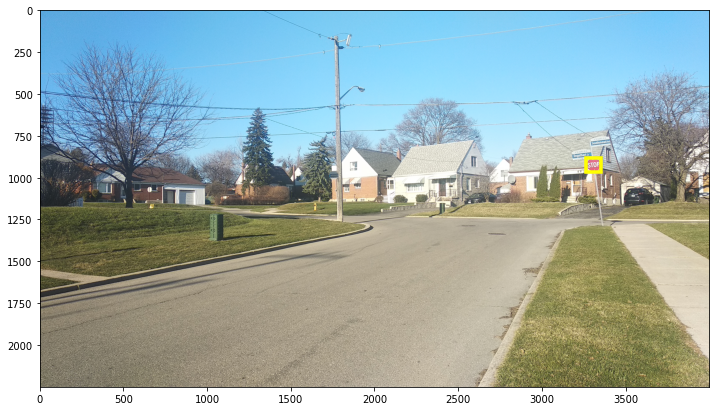

In [0]:
home_cropped_images = []

#We choose this image, since it should generalize well
#img = Image.open(master_path + "/GTSDB/sebData/6p.jpg")
#Just upload this model along with this colab file to github
img = Image.open("6p.jpg")
  
# Plot the full image
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(img, aspect='equal')

# Run the photo through the RCNN
transform = transforms.Compose([transforms.ToTensor()])
t = transform(img)
faster_rcnn_model.eval()
result = faster_rcnn_model([t])[0]

flag = 0
# Go through all the predictions created by the RCNN and see if stop signs prediction about the certainty threshold
for j in range(len(result['scores'])):

  # If there is a prediction, raise flag, draw the square on the previously full image, also crop then save the square
  if result['labels'][j] == 13 and result['scores'][j] > 0.5:
    print(result['scores'][j])
    flag = 1
    b = result['boxes'][j]
    ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, edgecolor='yellow', linewidth=3.5))
    margin = max(5, int((b[2]-b[0])*0.1))
    img_crop = img.crop((int(b[0])-margin, int(b[1])-margin, int(b[2])+margin, int(b[3])+margin))
    home_cropped_images.append([img_crop, "6p"])

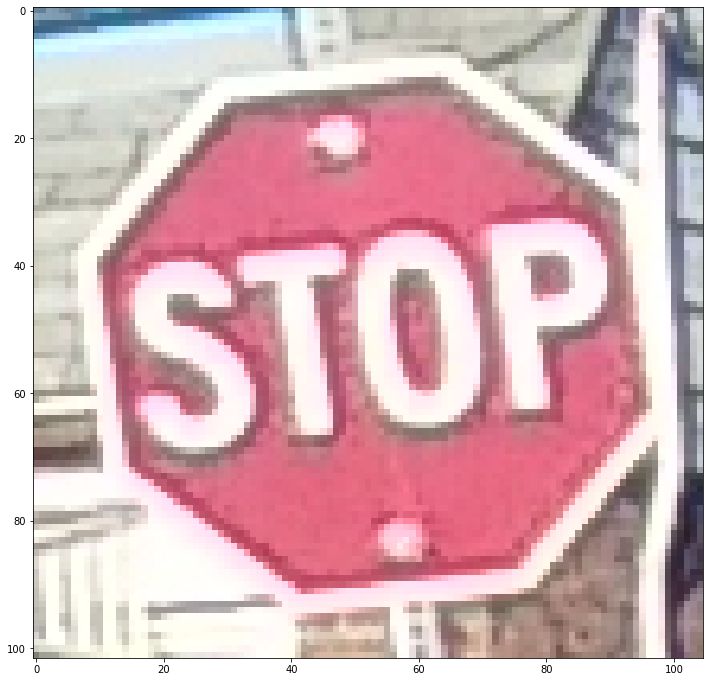

In [0]:
pred = []

for i in range(len(home_cropped_images)):
  # Draw the cropped image
  fig, ax = plt.subplots(figsize=(12, 12))
  ax.imshow(home_cropped_images[i][0], aspect='equal')

In [0]:
# Transform cropped images
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()])
#img = transform(cropped_images[i][0])
img = transform(img_crop)
img = img.reshape([1, img.shape[0], img.shape[1], img.shape[2]])

# Get features of cropped images
features = alexNet.features(img)

# Put features through trained CNN net
output = mod(features)
#instead of using argmax as usual, we also generate a confidence score
#39 is the index of the stop sign in GTSRB
print(torch.exp(output[0][39])/torch.sum(torch.exp(output[0])))

tensor(1.0000, grad_fn=<DivBackward0>)
